# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

### Основные шаги:
* Загрузите данные, путь к файлу:  /datasets/autos.csv.
* Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
* Подготовьте выборки для обучения моделей.
* Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
* Проанализируйте время обучения, время предсказания и качество моделей.
* Опираясь на критерии заказчика, выберете лучшую модель, проверьте её качество на тестовой выборке.

Примечания:
* Для оценки качества моделей применяйте метрику RMSE.
* Значение метрики RMSE должно быть меньше 2500.
* Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
* Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
* Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
* Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

### Описание данных
#### Признаки
* **DateCrawled** — дата скачивания анкеты из базы
* **VehicleType** — тип автомобильного кузова
* **egistrationYear** — год регистрации автомобиля
* **Gearbox** — тип коробки передач
* **Power** — мощность (л. с.)
* **Model** — модель автомобиля
* **Kilometer** — пробег (км)
* **RegistrationMonth** — месяц регистрации автомобиля
* **FuelType** — тип топлива
* **Brand** — марка автомобиля
* **Repaired** — была машина в ремонте или нет
* **DateCreated** — дата создания анкеты
* **NumberOfPictures** — количество фотографий автомобиля
* **PostalCode** — почтовый индекс владельца анкеты (пользователя)
* **LastSeen** — дата последней активности пользователя

#### Целевой признак
* **Price** — цена (евро)

## Подготовка данных

In [1]:
!pip install -q skimpy

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.0 requires numpy<1.23,>=1.18, but you have numpy 1.24.1 which is incompatible.


In [2]:
!pip install -q phik

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from skimpy import clean_columns
from sklearn.impute import KNNImputer
from sklearn.model_selection import KFold
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.compose import make_column_selector as selector

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

In [4]:
# подгружаем файл с данными
try:
    df = pd.read_csv('/datasets/autos.csv')
    
    print('Datasets load from Practicum cloud')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

    print('Datasets load from Web')

Datasets load from Practicum cloud


### Знакомство с данными

In [5]:
display(df.head(5))
print('-------------------------------------------------------------------------------------------------------')

display(df.info())
print('-------------------------------------------------------------------------------------------------------')

display(df.describe())
print('-------------------------------------------------------------------------------------------------------')

print('Кол-во пропусков:')
display(df.isna().sum())
print('-------------------------------------------------------------------------------------------------------')

print('Кол-во дубликатов =', df.duplicated().sum())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


-------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode  

None

-------------------------------------------------------------------------------------------------------


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


-------------------------------------------------------------------------------------------------------
Кол-во пропусков:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

-------------------------------------------------------------------------------------------------------
Кол-во дубликатов = 4


**Первичный анализ:**

* 354365 строк и 16 столбцов
* Присутствуют пропуски
* Максимальное значение мощности автомобиля в лошадинных силах = 20 000. Это весьма не реальный показатель.
* Минимальный год регистриции автомобиля 1000, максимальный 9999. Тоже не реальные показатели, т.к. в 1000 году машин не было, а 9999 год еще не настал)
* Минимальный пробег авто 5000, максимальный 150_000, но при этом много автомобилий имееют максимальный пробег = 150_000. Возможно это связано из за каких-нибудь ограничений
* Не правильный тип данных у столбцов: DateCrawled, DateCreated, LastSeen
* Средняя стоимость автомобилией 2700 евро
* Столбец с фото автомобилей пустой
* Есть 4 дубликата в данных, удалим их
* Больше всего пропусков в столбце о ремонте авто
* В датасете присутствуют неинформативные признаки, поэтому удалим их

### Обработка данных

Приведем все названия столбцов к типу snake_case

In [6]:
# приводим заголовки в соответствие стилю snake_case
df = clean_columns(df)

# проверяем стиль написания заголовков
df.columns

16 column names have been cleaned

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Посмотрим распределение пропусков по столбцам на гистограмме

<AxesSubplot:>

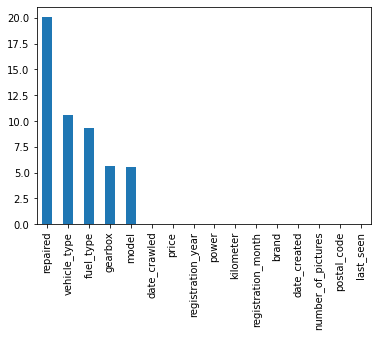

In [7]:
(df.isna().sum().sort_values(ascending=False) / df.shape[0] * 100).plot(kind='bar')

**Распределение пропусков составляют:**

* 20% в столбце repaired. Я предполагаю скорее всего владельцы пропустили это значение, потому что автомобиль не был в ремонте или просто скрыли информацию, чтобы автомобиль не казался менее привлекательным к покупке.
* 10% в столбце vehicle_type
* 9% в столбце fuel_type
* 5% в столбце gearBox
* 5% в столбце model

По остальным столбцам нельзя точно сказать причину пропущенных значений. Но я предположу по причине проблем с выгрузкой данных, так как на эти вопросы может дать ответ только владельцы автомобилей.

#### Избавимся от неинформатифных признаков для нашей задачи

Из всех признаков удалим сразу 6, так как они никак не влияют на нашу задачу. Это дата скачивания анкеты из базы, месяц регистрации автомобиля, дата создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты (пользователя), дата последней активности пользователя - все эти признаки не помогут узнать рыночную стоимость автомобиля. 

**Посмотрим на значения в столбце "last_seen"**

In [8]:
df['last_seen'] = pd.to_datetime(df['last_seen'], format='%Y-%m-%d %H:%M:%S')
df.last_seen.describe()

count                  354369
unique                 179150
top       2016-04-06 13:45:54
freq                       17
first     2016-03-05 14:15:08
last      2016-04-07 14:58:51
Name: last_seen, dtype: object

Последняя активность пользователя была 2016-04-07 14:58:51, а это значит что в столбце registration_year и registration_month данные не должны быть позже последней активности пользователя.

In [9]:
#избавимся от признаков, не влияющих на целевой признак
df.drop(columns=['date_crawled', 'date_created', 'number_of_pictures',
                    'postal_code', 'last_seen', 'registration_month'], axis=1, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Удалим все дубликаты в данных

In [11]:
print(df.duplicated().sum())

# удалим дубликаты
df.drop_duplicates(inplace=True)  
print(df.duplicated().sum())

45040
0


#### Рассмотрим и обработаем столбец: Price — цена (евро) (целевой признак)

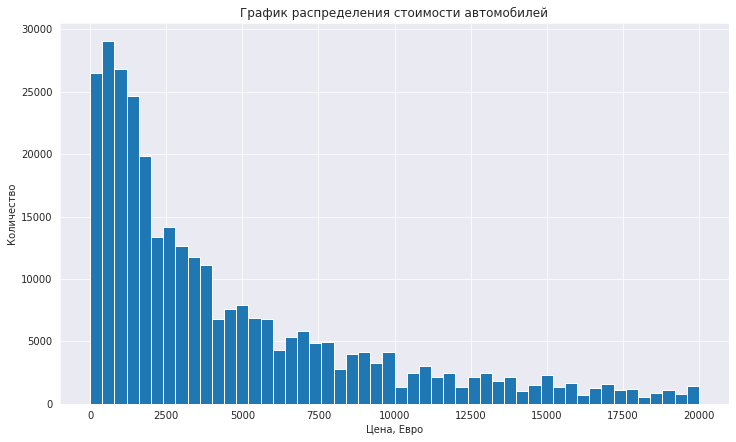

In [12]:
sns.set_style('darkgrid')
df.price.hist(bins=50,figsize=(12,7))
plt.title('График распределения стоимости автомобилей')
plt.xlabel('Цена, Евро')
plt.ylabel('Количество')
plt.show()

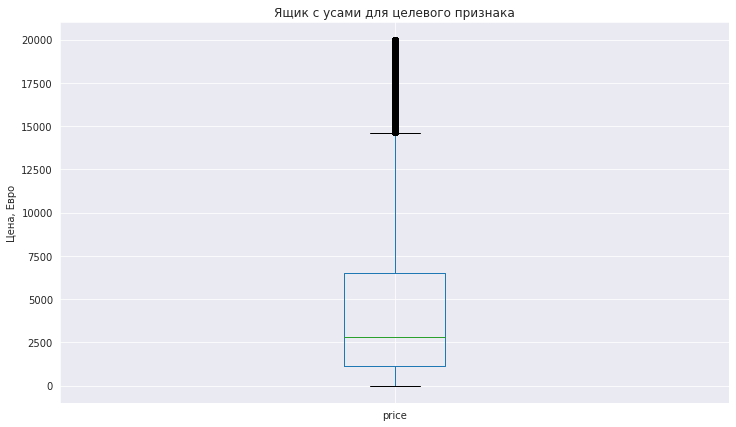

In [13]:
df.boxplot(['price'], figsize=(12,7))
plt.title('Ящик с усами для целевого признака')

plt.ylabel('Цена, Евро')
plt.show()

In [14]:
#на гистограмме и ящике с усами странные данные у цены равной 0 и у цены больше 15000, посмотрим по квантилям выбросы:
df.price.quantile([.05, 0.95])

0.05      200.0
0.95    14900.0
Name: price, dtype: float64

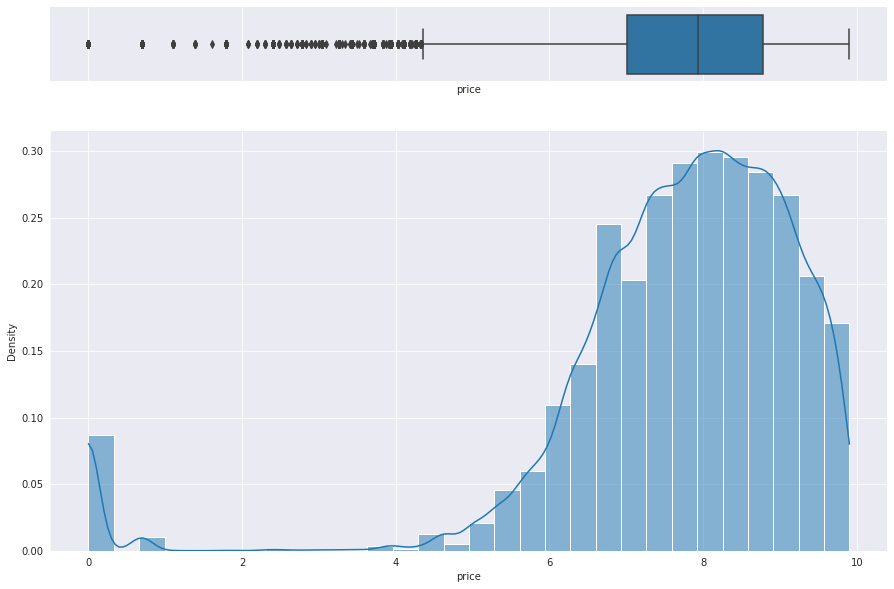

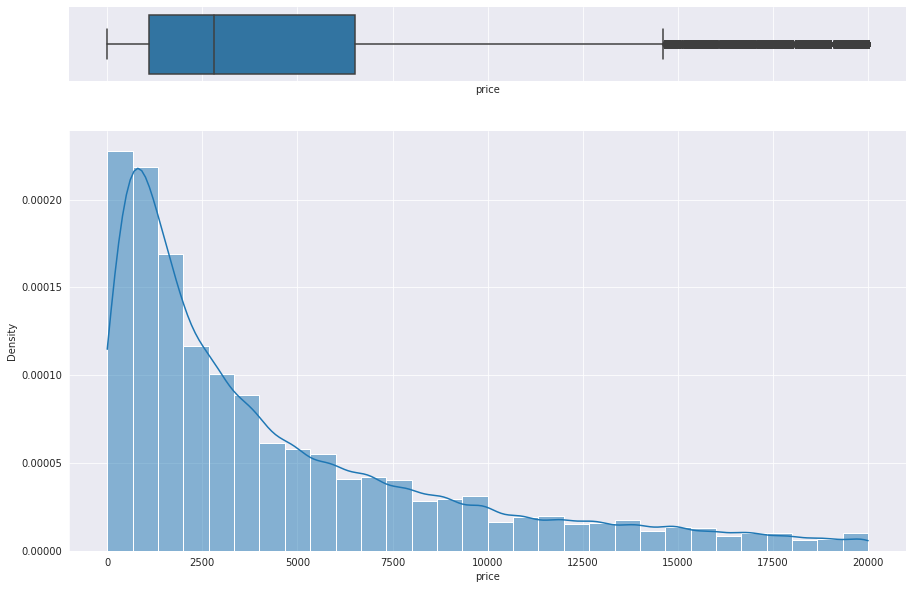

In [15]:
#КОД РЕВЬЮЕР
def hist_and_box_plot(x):
     f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(15,10))

     sns.boxplot(x=x, ax=ax_box)
     sns.histplot(x=x, bins=30, kde=True, stat='density', ax=ax_hist)

     ax_box.set(yticks=[])
     sns.despine(ax=ax_hist)
     sns.despine(ax=ax_box, left=True)
    
    
df_primer = df.copy()
hist_and_box_plot(np.log1p(df_primer['price']))
hist_and_box_plot(df_primer['price'])


Удалим данные стоимости автомобилей ниже 200евро и больше 14900евро, т.к. такие значения это выбросы. Владельцы машин могут указывать такую низкую цену только если машина не вподлежащем виде, а больше 14900евро это просто единичные случаи, поэтому они только исказят результаты.

In [16]:
#избавляемся от строк, где цена меньше 200 и больше 14900:
df = df.query('200 <= price <= 14900')

# проверим все ли значения удалились за нашим диапозоном
print(df.loc[df['price'] < 200]['price'].count())
df.loc[df['price'] > 14900]['price'].count()

0


0

#### Рассмотрим и обработаем столбец: vehicle_type - тип автомобильного кузова

In [17]:
display(df.vehicle_type.head())
df.vehicle_type.isna().sum()

0      NaN
2      suv
3    small
4    small
5    sedan
Name: vehicle_type, dtype: object

29005

Есть можество причин по которым могут быть пропуски в столбце типа автом. кузова, но просто удалить мы их не можем, т.к. это один из важных признаков и в нем большое кол-во пропусков, поэтому если удалим пропуски, то потеряются много других признаков. Заменим все пропуски на значение 'unknown'(неизвестный тип кузова).

In [18]:
#заменим пропуски на unknown
df['vehicle_type'] = df['vehicle_type'].fillna('unknown')
display(f'Пропусков в столбце vehicle_type = {df.vehicle_type.isna().sum()}')
df.vehicle_type.value_counts()

'Пропусков в столбце vehicle_type = 0'

sedan          71681
small          63197
wagon          51696
unknown        29005
bus            23950
convertible    15919
coupe          12404
suv             8588
other           2804
Name: vehicle_type, dtype: int64

#### Рассмотрим и обработаем столбец: registration_year - год регистрации автомобиля

In [19]:
df.registration_year.value_counts()

2000    18889
2005    18369
1999    17767
2001    16577
2003    16458
        ...  
3800        1
4800        1
2290        1
1930        1
1946        1
Name: registration_year, Length: 132, dtype: int64

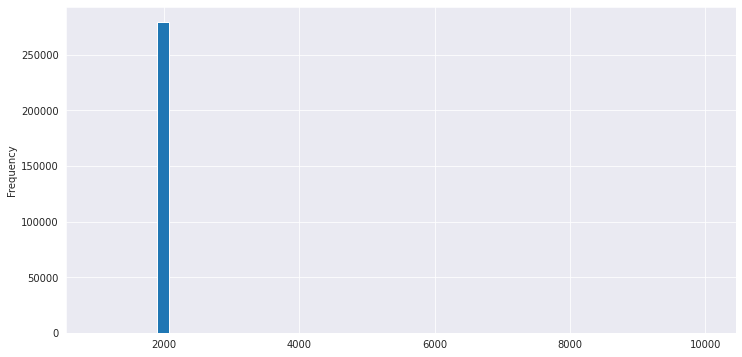

In [20]:
df.registration_year.plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.show()

Посмотрим по персантилиям года

In [21]:
perc = np.arange(0, 1, 0.05)
df['registration_year'].describe(percentiles=perc)

count    279244.000000
mean       2003.799476
std          69.715315
min        1000.000000
0%         1000.000000
5%         1992.000000
10%        1995.000000
15%        1997.000000
20%        1998.000000
25%        1999.000000
30%        2000.000000
35%        2000.000000
40%        2001.000000
45%        2002.000000
50%        2003.000000
55%        2004.000000
60%        2005.000000
65%        2005.000000
70%        2006.000000
75%        2007.000000
80%        2008.000000
85%        2010.000000
90%        2012.000000
95%        2016.000000
max        9999.000000
Name: registration_year, dtype: float64

Пока что все очевидные выбросы заполним заглушки, чтобы потом заполнить методом ближайших соседей KNN для повышения качества моделей.

In [22]:
# поставим заглушки (np.nan) вместо выбросов в признаке 'registration_year'
df.loc[df['registration_year'] < 1950, 'registration_year'] = np.nan
df.loc[df['registration_year'] > 2016, 'registration_year'] = np.nan

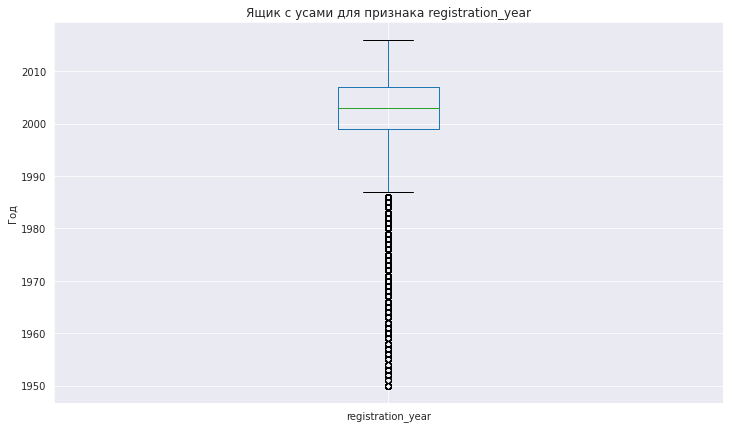

In [23]:
df.boxplot(['registration_year'], figsize=(12,7))
plt.title('Ящик с усами для признака registration_year')

plt.ylabel('Год')
plt.show()

#### Рассмотрим и обработаем столбец: gearbox - тип коробки передач

In [24]:
df.query('gearbox.isna()')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
15,450,small,NaN,NaN,0,ka,5000,petrol,ford,NaN
16,300,unknown,2016.0,NaN,60,polo,150000,petrol,volkswagen,NaN
32,245,sedan,1994.0,NaN,0,golf,150000,petrol,volkswagen,no
37,1500,unknown,2016.0,NaN,0,kangoo,150000,gasoline,renault,no
69,1200,coupe,2001.0,NaN,0,astra,150000,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
354253,1250,unknown,NaN,NaN,0,corsa,150000,petrol,opel,NaN
354285,3500,small,2001.0,NaN,75,corsa,90000,petrol,opel,no
354305,3500,unknown,1995.0,NaN,0,polo,150000,NaN,volkswagen,NaN
354329,350,small,1996.0,NaN,65,punto,150000,NaN,fiat,NaN


Признак о данных коробке передач важен для нашей задачи, он сильно может повлиять на модель при обучении. Поэтому лучше заполнить пропуски методом ближайших соседей KNN, так мы не потеряем большое количество данных и улучшим метрику.

In [25]:
# для последующей замены строковых значений на числовые поставим заглушку
df['gearbox'] = df['gearbox'].fillna('unknown')

In [26]:
# заменяем строковые значения на числовые в признаке 'gearbox'
df['gearbox'] = [x.replace('manual', '1') for x in df['gearbox']]
df['gearbox'] = [x.replace('auto', '0') for x in df['gearbox']]

In [27]:
# заглушку заменяем на пропуски, котоыре будут заполнены далее
df.loc[df['gearbox'] == 'unknown', 'gearbox'] = np.nan
df.gearbox = df.gearbox.astype('float64')

In [28]:
display(df.info())
df.gearbox.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279244 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              279244 non-null  int64  
 1   vehicle_type       279244 non-null  object 
 2   registration_year  266619 non-null  float64
 3   gearbox            265715 non-null  float64
 4   power              279244 non-null  int64  
 5   model              263934 non-null  object 
 6   kilometer          279244 non-null  int64  
 7   fuel_type          253706 non-null  object 
 8   brand              279244 non-null  object 
 9   repaired           223172 non-null  object 
dtypes: float64(2), int64(3), object(5)
memory usage: 23.4+ MB


None

(279244,)

Затем методом KNN заполним пропуски

#### Рассмотрим и обработаем столбец: power - мощность (л. с.)

In [29]:
df.power.value_counts()

0       29988
75      18515
60      11945
150     11727
101     10693
        ...  
2461        1
6006        1
6018        1
612         1
307         1
Name: power, Length: 661, dtype: int64

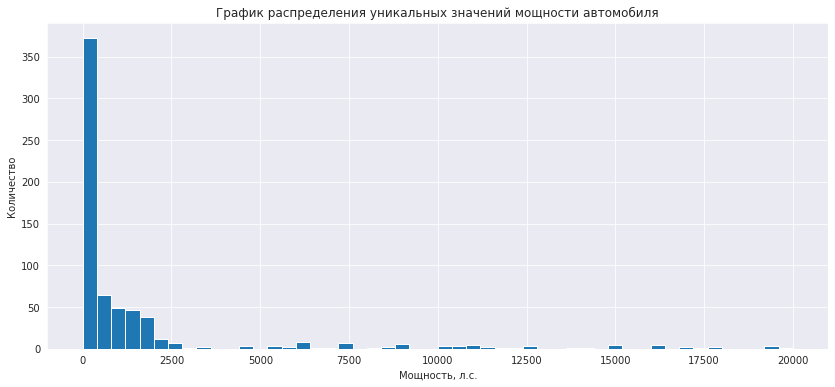

In [30]:
pd.Series(list(df.power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(14,6), grid=True, bins=50)
plt.title('График распределения уникальных значений мощности автомобиля')
plt.xlabel('Мощность, л.с.')
plt.ylabel('Количество')
plt.show()

In [31]:
df['power'].describe(percentiles=perc)

count    279244.000000
mean        109.305718
std         200.372760
min           0.000000
0%            0.000000
5%            0.000000
10%           0.000000
15%          54.000000
20%          60.000000
25%          69.000000
30%          75.000000
35%          82.000000
40%          90.000000
45%         101.000000
50%         103.000000
55%         109.000000
60%         116.000000
65%         122.000000
70%         132.000000
75%         140.000000
80%         150.000000
85%         163.000000
90%         177.000000
95%         205.000000
max       20000.000000
Name: power, dtype: float64

Как мы заметили очень много значений равных 0, но это скорее всего аномалии. Поэтому в признаке power оставим только данные похожие на реальные на сегодняшний день: Самое мощное по состоянию на 2023 год легковое авто имеет примерно 1600лс, а самое слабое имеет примерно 70лс, поэтому заполним NaN-ами данные по этим границам, чтобы дальше заполнить их методом KNN во избежание потери большого количества данных.

In [32]:
# поставим заглушки (np.nan) вместо выбросов в признаке 'power'
df.loc[df['power'] < 70, 'power'] = np.nan
df.loc[df['power'] > 1300, 'power'] = np.nan

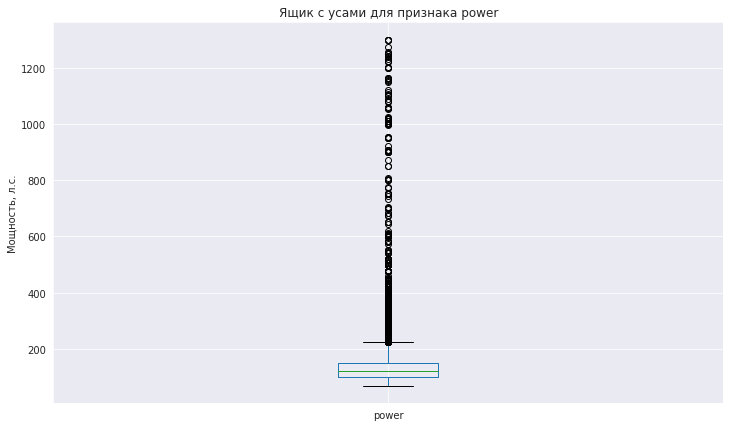

In [33]:
df.boxplot(['power'], figsize=(12,7))
plt.title('Ящик с усами для признака power')

plt.ylabel('Мощность, л.с.')
plt.show()

#### Рассмотрим и обработаем столбец: model - модель автомобиля

In [34]:
df.query('model.isna()')

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
81,350,small,1997.0,1.0,NaN,NaN,150000,NaN,fiat,yes
135,1450,sedan,1992.0,1.0,136.0,NaN,150000,NaN,audi,no
151,6799,small,2009.0,NaN,NaN,NaN,20000,petrol,volkswagen,no
160,500,small,1999.0,1.0,NaN,NaN,150000,petrol,renault,no
161,1495,wagon,2001.0,NaN,NaN,NaN,150000,gasoline,volkswagen,NaN
...,...,...,...,...,...,...,...,...,...,...
354234,5000,sedan,2002.0,0.0,170.0,NaN,150000,petrol,audi,no
354245,560,small,2001.0,0.0,170.0,NaN,90000,petrol,fiat,yes
354321,9400,wagon,2007.0,1.0,200.0,NaN,150000,gasoline,sonstige_autos,yes
354351,1900,unknown,2000.0,1.0,110.0,NaN,150000,NaN,volkswagen,no


Модель автомобиля это основной фактор, который на прямую влияет на цену, поэтому заменим пропуски на значение 'unknown', потому что делая что либо другое с этим признаком приведет к потери ценных данных.

In [35]:
#заменяю NaN на 'unknown':
df['model'] = df['model'].fillna('unknown')
df.model.value_counts()

golf                  21395
other                 20585
unknown               15310
3er                   15149
polo                   9639
                      ...  
q3                        3
serie_3                   2
gl                        2
range_rover_evoque        1
serie_1                   1
Name: model, Length: 251, dtype: int64

#### Рассмотрим и обработаем столбец: kilometer - пробег (км)

In [36]:
display(df.kilometer.value_counts())
df.kilometer.isna().sum()

150000    188871
125000     30146
100000     11936
90000       9319
80000       7914
70000       6739
60000       5547
50000       4619
5000        4119
40000       3459
30000       3056
20000       2764
10000        755
Name: kilometer, dtype: int64

0

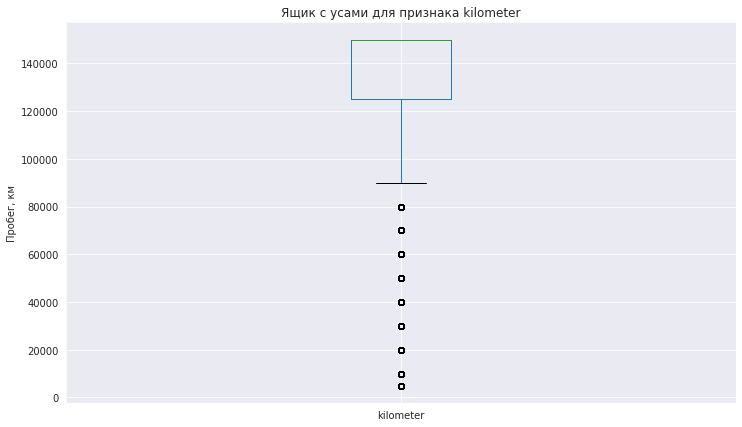

In [37]:
df.boxplot(['kilometer'], figsize=(12,7))
plt.title('Ящик с усами для признака kilometer')

plt.ylabel('Пробег, км')
plt.show()

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279244 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              279244 non-null  int64  
 1   vehicle_type       279244 non-null  object 
 2   registration_year  266619 non-null  float64
 3   gearbox            265715 non-null  float64
 4   power              208524 non-null  float64
 5   model              279244 non-null  object 
 6   kilometer          279244 non-null  int64  
 7   fuel_type          253706 non-null  object 
 8   brand              279244 non-null  object 
 9   repaired           223172 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 23.4+ MB


В признаке kilometer выбросов и пропусков нету

#### Рассмотрим и обработаем столбец: fuel_type   - тип топлива

In [39]:
df.fuel_type.value_counts()

petrol      172755
gasoline     75402
lpg           4656
cng            504
hybrid         172
other          140
electric        77
Name: fuel_type, dtype: int64

In [40]:
df.fuel_type.isna().sum()

25538

Не будем удалять пропуски, так как пропадет много других признаков, тогда пропуски заменим на значение 'other'(другой тип топлива).

In [41]:
# заполним пропуски как "other"
df['fuel_type'] = df['fuel_type'].fillna('other')
df.fuel_type.value_counts()

petrol      172755
gasoline     75402
other        25678
lpg           4656
cng            504
hybrid         172
electric        77
Name: fuel_type, dtype: int64

#### Рассмотрим и обработаем столбец: brand - марка автомобиля

In [42]:
df.brand.value_counts()

volkswagen        57575
opel              31247
bmw               27758
mercedes_benz     25538
audi              22017
ford              20268
renault           14648
peugeot            9297
fiat               8053
seat               5701
mazda              4769
smart              4710
skoda              4589
citroen            4507
toyota             4044
nissan             4023
hyundai            3047
volvo              2647
mitsubishi         2591
honda              2478
mini               2421
sonstige_autos     2240
kia                2051
suzuki             2031
alfa_romeo         1976
chevrolet          1494
chrysler           1227
dacia               805
daihatsu            678
subaru              637
jeep                552
daewoo              478
saab                456
trabant             435
porsche             433
land_rover          412
lancia              406
rover               406
jaguar              403
lada                196
Name: brand, dtype: int64

In [43]:
df.brand.isna().sum()

0

В марках автомобиля нету пропусков и неявных дубликатов

#### Рассмотрим и обработаем столбец: repaired - была машина в ремонте или нет

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279244 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              279244 non-null  int64  
 1   vehicle_type       279244 non-null  object 
 2   registration_year  266619 non-null  float64
 3   gearbox            265715 non-null  float64
 4   power              208524 non-null  float64
 5   model              279244 non-null  object 
 6   kilometer          279244 non-null  int64  
 7   fuel_type          279244 non-null  object 
 8   brand              279244 non-null  object 
 9   repaired           223172 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 23.4+ MB


In [45]:
df.repaired.unique()

array([nan, 'no', 'yes'], dtype=object)

In [46]:
df.repaired.isna().sum()

56072

Это один из самых значимых признаков, поэтому для сохранения его информативности заполним все пропуски методом KNN для этого нужно перевести столбец в числовой тип данных.

In [47]:
df.repaired.value_counts()

no     193723
yes     29449
Name: repaired, dtype: int64

In [48]:
#заменим в repaired значение yes на 1, no - на 0, чтобы затем могли заполнить пропуски методом KNN
df.loc[(df.repaired == 'yes'), 'repaired'] = 1
df.loc[(df.repaired == 'no'), 'repaired'] = 0

df.repaired = df.repaired.astype('float64')

In [49]:
df.repaired.shape

(279244,)

#### KNN

Создадим список столбцов (признаков) датасета df с числовым типом данных, в которых есть пропуски.

In [50]:
number_nan_columns = ['power', 
                     'registration_year', 
                     'gearbox', 
                     'repaired']

In [51]:
# создаем объект KNNImputer
imputer = KNNImputer(
    n_neighbors = 5, 
    copy = False
)

In [52]:
%%time
# для заполнения пропусков методом ближайших соседей 
# обучаем и трансформируем числовые признаки датасета df, 
# в которых есть пропуски, с помощью объекта KNNImputer

df[number_nan_columns] = imputer.fit_transform(df[number_nan_columns])

CPU times: user 37min 32s, sys: 17min 17s, total: 54min 50s
Wall time: 54min 53s


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279244 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              279244 non-null  int64  
 1   vehicle_type       279244 non-null  object 
 2   registration_year  279244 non-null  float64
 3   gearbox            279244 non-null  float64
 4   power              279244 non-null  float64
 5   model              279244 non-null  object 
 6   kilometer          279244 non-null  int64  
 7   fuel_type          279244 non-null  object 
 8   brand              279244 non-null  object 
 9   repaired           279244 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 23.4+ MB


In [54]:
df.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

#### Посмотрим корреляцию между признаками

In [55]:
display(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279244 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              279244 non-null  int64  
 1   vehicle_type       279244 non-null  object 
 2   registration_year  279244 non-null  float64
 3   gearbox            279244 non-null  float64
 4   power              279244 non-null  float64
 5   model              279244 non-null  object 
 6   kilometer          279244 non-null  int64  
 7   fuel_type          279244 non-null  object 
 8   brand              279244 non-null  object 
 9   repaired           279244 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 23.4+ MB


None

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,unknown,1993.0,1.0,103.8,golf,150000,petrol,volkswagen,0.2
2,9800,suv,2004.0,0.0,163.0,grand,125000,gasoline,jeep,0.0
3,1500,small,2001.0,1.0,75.0,golf,150000,petrol,volkswagen,0.0
4,3600,small,2008.0,1.0,119.0,fabia,90000,gasoline,skoda,0.0
5,650,sedan,1995.0,1.0,102.0,3er,150000,petrol,bmw,1.0


In [56]:
df.corr() # Считаю корреляцию Пирсона

,price,registration_year,gearbox,power,kilometer,repaired
price,1.000000,0.420328,-0.196780,0.328345,-0.300424,-0.231812
registration_year,0.420328,1.000000,-0.003443,0.026560,-0.185736,-0.092510
gearbox,-0.196780,-0.003443,1.000000,-0.393486,-0.037424,0.016181
power,0.328345,0.026560,-0.393486,1.000000,0.107033,-0.031172
kilometer,-0.300424,-0.185736,-0.037424,0.107033,1.000000,0.076306
repaired,-0.231812,-0.092510,0.016181,-0.031172,0.076306,1.000000


Построим еще одну таблицу корреляции, только более сложную phik, в ней ищется не только линейная зависимость, но и не линейная, а метод Пирсона в пандасе исключительно ищет только линейную зависимость.

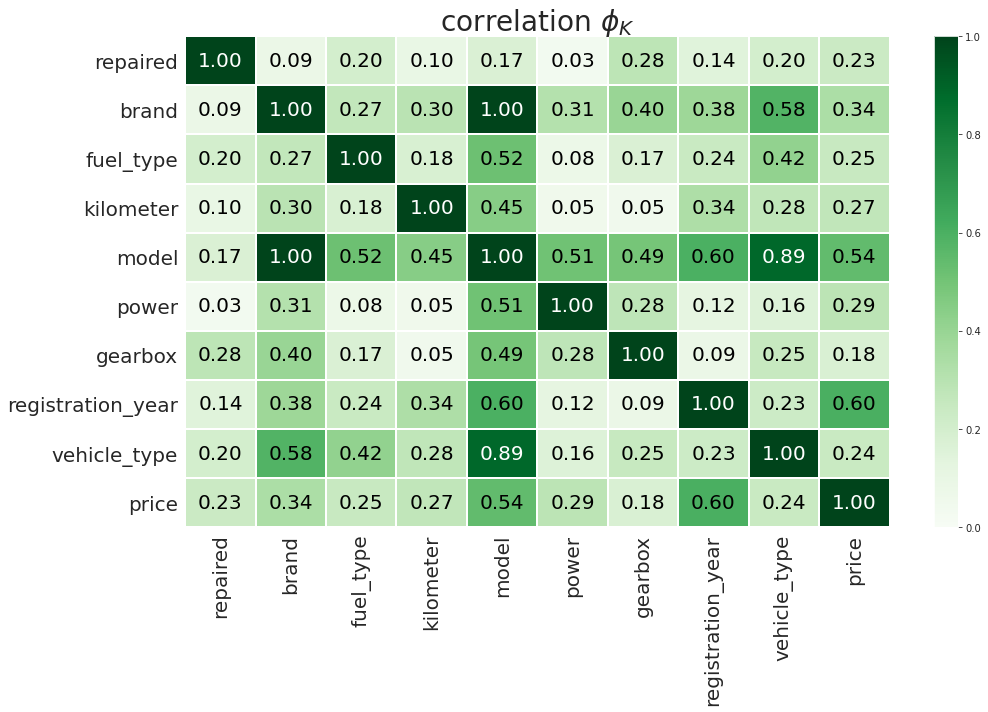

In [57]:
from phik.report import correlation_report, plot_correlation_matrix

interval_cols = df.select_dtypes('number').columns.tolist()
phik_overview = df.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns,
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens",
                        title=r"correlation $\phi_K$",
                        fontsize_factor=2,
                        figsize=(15, 10))
plt.tight_layout()

Отобразим наиболее коррелирующие признаки для нашего целевого признака(price)

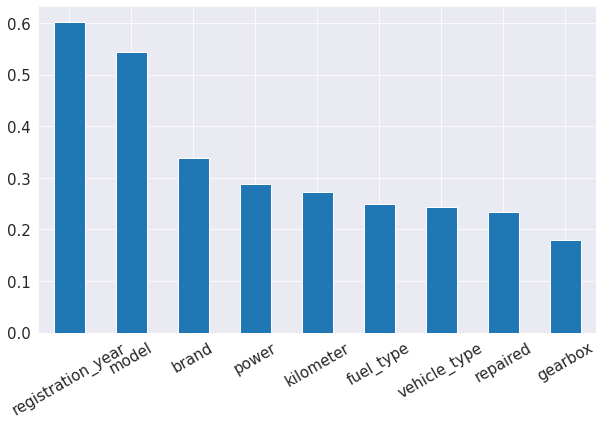

In [58]:
phik_overview['price'].sort_values(ascending=False)[1:].plot(kind='bar', figsize=(10, 6), fontsize=15)
plt.xticks(rotation=30)
plt.show()

#### Вывод после детального анализа и предобработки данных:
* Избавился от:
    * признаков, которые никак не влияют на целевой признак
    * дубликатов
    * выбросов в целевом признаке и признаках
    * верблюжьего стиля
* Заполнил пропуски в:
    * fueltype значением 'other'
    * vehicletype, model значением 'unknown'
    * power, registration_year, gearbox, repaired методом ближайших соседей (KNN)
* Цена больше всего зависит от:
    * от года регистрации и модели автомобиля
    
В результате обработки данных датафрейм сократился на 21%, стало 279_244 строк.

## Обучение моделей

Проверим не появились ли заново новые дубликаты, так как очень важно чтобы при кодирование признаков не было лишних данных.

In [59]:
df.duplicated().sum()

2314

Как видим образовались новые дубликаты, поэтому удалим их.

In [60]:
# удалим дубликаты
df.drop_duplicates(inplace=True)  
print(df.duplicated().sum())

0


### Подготовка данных для обучения моделей

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276930 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              276930 non-null  int64  
 1   vehicle_type       276930 non-null  object 
 2   registration_year  276930 non-null  float64
 3   gearbox            276930 non-null  float64
 4   power              276930 non-null  float64
 5   model              276930 non-null  object 
 6   kilometer          276930 non-null  int64  
 7   fuel_type          276930 non-null  object 
 8   brand              276930 non-null  object 
 9   repaired           276930 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 23.2+ MB


Выделим признаки и целевой признак(без кодирования).

In [62]:
features = df.drop('price', axis=1)
target = df.price

In [63]:
# создадим список столбцов (признаков), 
# относящиеся к категориальному типу данных
categorical_columns_selector = selector(dtype_include = object)
categorical_columns = categorical_columns_selector(features)
categorical_columns

['vehicle_type', 'model', 'fuel_type', 'brand']

In [64]:
# создадим список столбцов (признаков), 
# относящиеся к числовому типу данных
numerical_columns_selector = selector(dtype_include = ['int64', 'float64'])
numerical_columns = numerical_columns_selector(features)
numerical_columns

['registration_year', 'gearbox', 'power', 'kilometer', 'repaired']

#### Кодируем признаки методом OneHotEncoder (для простых/линейных моделей)

**OneHotEncoder**, это тоже самое что и get_dummies, но он используется в промышленных маштабах, поэтому буду сразу делать им, так как нам сказали get_dummies не применяют в реальных проектах, его применяют только в маленьких проектах, чтобы быстро сделать и показать.

In [65]:
# создаем объект OneHotEncoder, применив параметр drop = 'first'
# устраняем проблему dummy-ловушки
ohe = OneHotEncoder(sparse = False, drop='first')

**Разбиваем данные на четыре выборки**

In [66]:
features_train_ohe, features_valid_ohe, target_train_ohe, target_valid_ohe = train_test_split(features, target, \
        test_size=0.25, random_state=12345)

In [67]:
# создадим датасет, включающий категориальыне признаки для выборок features_train_ohe, features_valid_ohe
features_train_ohe_categorical = features_train_ohe[categorical_columns]
features_valid_ohe_categorical = features_valid_ohe[categorical_columns]
# выведем тип данных признаков датасетов features_train_ohe_categorical, features_valid_ohe_categorical
display(features_train_ohe_categorical.dtypes)
display(features_valid_ohe_categorical.dtypes)

# создадим датасет, включающий числовые признаки выборок features_train_ohe, features_valid_ohe 
features_train_ohe_numerical = features_train_ohe[numerical_columns]
features_valid_ohe_numerical = features_valid_ohe[numerical_columns]
# выведем тип данных признаков датасетов features_train_ohe_numerical, features_valid_ohe_numerical
display(features_train_ohe_numerical.dtypes)
display(features_valid_ohe_numerical.dtypes)

vehicle_type    object
model           object
fuel_type       object
brand           object
dtype: object

vehicle_type    object
model           object
fuel_type       object
brand           object
dtype: object

registration_year    float64
gearbox              float64
power                float64
kilometer              int64
repaired             float64
dtype: object

registration_year    float64
gearbox              float64
power                float64
kilometer              int64
repaired             float64
dtype: object

In [68]:
# создаем датафрейм df_features_train_ohe, в который сохраняем
# обученный и трансформированный объект OneHotEncoder
df_features_train_ohe = pd.DataFrame(
    ohe.fit_transform(features_train_ohe_categorical), 
    columns = ohe.get_feature_names())
display(df_features_train_ohe)

# создаем датафрейм df_features_valid_ohe, в который сохраняем
# трансформированный объект OneHotEncoder
df_features_valid_ohe = pd.DataFrame(
    ohe.transform(features_valid_ohe_categorical), 
    columns = ohe.get_feature_names())
display(df_features_valid_ohe)

,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_unknown,x0_wagon,x1_145,x1_147,...,x3_seat,x3_skoda,x3_smart,x3_sonstige_autos,x3_subaru,x3_suzuki,x3_toyota,x3_trabant,x3_volkswagen,x3_volvo
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207694,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
207695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,x0_convertible,x0_coupe,x0_other,x0_sedan,x0_small,x0_suv,x0_unknown,x0_wagon,x1_145,x1_147,...,x3_seat,x3_skoda,x3_smart,x3_sonstige_autos,x3_subaru,x3_suzuki,x3_toyota,x3_trabant,x3_volkswagen,x3_volvo
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69228,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
69229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69230,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69231,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Промаштабируем только численные признаки**

In [69]:
print(features_train_ohe.shape)
features_valid_ohe.shape

(207697, 9)


(69233, 9)

In [70]:
scaler_ohe = MinMaxScaler()
features_train_ohe_numerical = scaler_ohe.fit_transform(features_train_ohe_numerical)
features_valid_ohe_numerical = scaler_ohe.transform(features_valid_ohe_numerical)
print(features_train_ohe.shape)
features_valid_ohe.shape

(207697, 9)


(69233, 9)

In [71]:
# объединим датасет с числовыми признаками features_train_ohe_numerical
# с датасетом df_features_train_ohe, содержащем закодированные данные категориальных признаков
features_train_ohe = np.concatenate([features_train_ohe_numerical, 
                                  df_features_train_ohe], 
                                 axis = 1)

# объединим датасет с числовыми признаками features_valid_ohe_numerical
# с датасетом df_features_valid_ohe, содержащем закодированные данные категориальных признаков
features_valid_ohe = np.concatenate([features_valid_ohe_numerical, 
                                  df_features_valid_ohe], 
                                 axis = 1)

In [72]:
# выведем на экран размер обновленного датасета с признаками features_train_ohe
display(features_train_ohe.shape)
# выведем на экран размер обновленного датасета с признаками features_valid_ohe
features_valid_ohe.shape

(207697, 308)

(69233, 308)

#### Кодируем признаки методом OrdinalEncoder (для сложных моделей, таких как деревья и CatBoostRegressor)

In [73]:
oe = OrdinalEncoder()

**Разбиваем данные на четыре выборки**

In [74]:
features_train_oe, features_valid_oe, target_train_oe, target_valid_oe = train_test_split(features, target, \
        test_size=0.25, random_state=12345)

In [75]:
# создадим датасет, включающий категориальыне признаки для выборок features_train_oe, features_valid_oe
features_train_oe_categorical = features_train_oe[categorical_columns]
features_valid_oe_categorical = features_valid_oe[categorical_columns]
# выведем тип данных признаков датасетов features_train_oe_categorical, features_valid_oe_categorical
display(features_train_oe_categorical.dtypes)
display(features_valid_oe_categorical.dtypes)

# создадим датасет, включающий числовые признаки выборок features_train_oe, features_valid_oe 
features_train_oe_numerical = features_train_oe[numerical_columns]
features_valid_oe_numerical = features_valid_oe[numerical_columns]
# выведем тип данных признаков датасетов features_train_oe_numerical, features_valid_oe_numerical
display(features_train_oe_numerical.dtypes)
display(features_valid_oe_numerical)

vehicle_type    object
model           object
fuel_type       object
brand           object
dtype: object

vehicle_type    object
model           object
fuel_type       object
brand           object
dtype: object

registration_year    float64
gearbox              float64
power                float64
kilometer              int64
repaired             float64
dtype: object

,registration_year,gearbox,power,kilometer,repaired
134947,1998.0,1.0,193.0,150000,1.0
26115,1997.0,0.0,130.0,150000,1.0
299931,1999.0,1.0,75.0,150000,1.0
147349,2003.0,0.0,231.0,150000,0.2
91921,1998.0,1.0,100.2,80000,0.0
...,...,...,...,...,...
60073,2006.0,0.0,185.0,150000,0.0
183401,1999.0,1.0,116.0,150000,0.0
304698,2004.0,1.0,105.4,150000,0.4
298243,1983.0,1.0,112.0,150000,0.0


In [76]:
# создаем датафрейм df_features_train_oe, в который сохраняем
# обученный и трансформированный объект OrdinalEncoder
df_features_train_oe = pd.DataFrame(
    oe.fit_transform(features_train_oe_categorical), 
    columns = features_train_oe_categorical.columns)
display(df_features_train_oe)

# создаем датафрейм df_features_valid_oe, в который сохраняем
# трансформированный объект OrdinalEncoder
df_features_valid_oe = pd.DataFrame(
    oe.transform(features_valid_oe_categorical), 
    columns = features_valid_oe_categorical.columns)
display(df_features_valid_oe)

,vehicle_type,model,fuel_type,brand
0,7.0,98.0,6.0,10.0
1,4.0,149.0,6.0,27.0
2,3.0,228.0,2.0,9.0
3,4.0,205.0,6.0,24.0
4,5.0,106.0,6.0,32.0
...,...,...,...,...
207692,8.0,95.0,6.0,20.0
207693,8.0,10.0,6.0,25.0
207694,4.0,95.0,2.0,20.0
207695,8.0,29.0,5.0,1.0


,vehicle_type,model,fuel_type,brand
0,4.0,15.0,6.0,2.0
1,4.0,154.0,6.0,10.0
2,5.0,102.0,6.0,10.0
3,6.0,242.0,4.0,2.0
4,5.0,83.0,6.0,24.0
...,...,...,...,...
69228,6.0,245.0,2.0,39.0
69229,8.0,250.0,6.0,24.0
69230,4.0,136.0,6.0,27.0
69231,5.0,116.0,6.0,38.0


In [77]:
# объединим датасет с числовыми признаками features_train_oe_numerical
# с датасетом df_features_train_oe, содержащем закодированные данные категориальных признаков
features_train_oe = np.concatenate([features_train_oe_numerical, 
                                  df_features_train_oe], 
                                 axis = 1)

# объединим датасет с числовыми признаками features_valid_oe_numerical
# с датасетом df_features_valid_oe, содержащем закодированные данные категориальных признаков
features_valid_oe = np.concatenate([features_valid_oe_numerical, 
                                  df_features_valid_oe], 
                                 axis = 1)

In [78]:
# выведем на экран размер обновленного датасета с признаками features_train_oe
display(features_train_oe.shape)
# выведем на экран размер обновленного датасета с признаками features_valid_oe
features_valid_oe.shape

(207697, 9)

(69233, 9)

В маштабирование сложные модели не нуждаются

### Обучим модели

In [79]:
# для создания собственной метрики создадим функцию,
# обеспечивающую расчет rmse для моделей

def rmse_metric(target, predicted):
    rmse = mean_squared_error(target, predicted, squared = False)
    return rmse

In [80]:
rmse_score = make_scorer(rmse_metric, greater_is_better = False) #greater_is_better = False - минимизирует функцию

#### Модель LinearRegression

In [81]:
%%time
model_lin_ohe = LinearRegression()

lin_params = {
    'fit_intercept':[True,False],
    'normalize':[True,False],
    'copy_X':[True, False]
    }

rscv_model_lin_ohe = RandomizedSearchCV(model_lin_ohe, lin_params, scoring=rmse_score, cv=5, refit=True, verbose=1)

rscv_model_lin_ohe.fit(features_train_ohe, target_train_ohe)
best_model_lin_ohe = rscv_model_lin_ohe.best_estimator_
best_score_lin_ohe = rscv_model_lin_ohe.best_score_
print(best_model_lin_ohe)
print(abs(best_score_lin_ohe))

results_lin = pd.DataFrame(rscv_model_lin_ohe.cv_results_)
results_lin['mean_test_score'] = - results_lin['mean_test_score']
results_lin['mean_test_score'].head()

index_lin = rscv_model_lin_ohe.best_index_
fit_time_lin = results_lin['mean_fit_time'][index_lin]
score_time_lin = results_lin['mean_score_time'][index_lin]

Fitting 5 folds for each of 8 candidates, totalling 40 fits
LinearRegression(fit_intercept=False, normalize=True)
2322.922621786181
CPU times: user 8min 36s, sys: 3min 49s, total: 12min 25s
Wall time: 12min 27s


#### Модель RandomForestRegressor

In [82]:
kf_tree = KFold(5, shuffle=True, random_state=12345)

In [83]:
%%time
model_forest_oe = RandomForestRegressor(random_state=12345)

forest_params = {
    'max_depth': range(1, 20),
    'min_samples_leaf': range(1, 6, 2),
    'n_estimators': range(10, 101, 10),
    }


rscv_model_forest_oe = RandomizedSearchCV(model_forest_oe, forest_params, scoring=rmse_score, cv=kf_tree,
                                         refit=True, verbose=1, n_jobs=-1, random_state=12345)

rscv_model_forest_oe.fit(features_train_oe, target_train_oe)
best_model_forest_oe = rscv_model_forest_oe.best_estimator_
print(best_model_forest_oe)
print(rscv_model_forest_oe.best_params_)
print(abs(rscv_model_forest_oe.best_score_))

results_forest = pd.DataFrame(rscv_model_forest_oe.cv_results_)
results_forest['mean_test_score'] = - results_forest['mean_test_score']
results_forest['mean_test_score'].head()

index_forest = rscv_model_forest_oe.best_index_
fit_time_forest = results_forest['mean_fit_time'][index_forest]
score_time_forest = results_forest['mean_score_time'][index_forest]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
RandomForestRegressor(max_depth=17, min_samples_leaf=3, n_estimators=50,
                      random_state=12345)
{'n_estimators': 50, 'min_samples_leaf': 3, 'max_depth': 17}
1559.634824344599
CPU times: user 8min 27s, sys: 8.04 s, total: 8min 35s
Wall time: 8min 35s


#### Модель DecisionTreeRegressor

In [84]:
%%time
model_tree_oe = DecisionTreeRegressor(random_state=12345)

tree_params = {
    'max_depth': range(1, 100),
    'min_samples_leaf': range(1, 6)
    }

rscv_model_tree_oe = RandomizedSearchCV(model_tree_oe, tree_params, scoring=rmse_score, cv=kf_tree,
                                       refit=True, verbose=1, n_jobs=-1, random_state=12345)

rscv_model_tree_oe.fit(features_train_oe, target_train_oe)
best_model_tree_oe = rscv_model_tree_oe.best_estimator_
print(best_model_tree_oe)
print(rscv_model_tree_oe.best_params_)
print(abs(rscv_model_tree_oe.best_score_))

results_tree = pd.DataFrame(rscv_model_tree_oe.cv_results_)
results_tree['mean_test_score'] = - results_tree['mean_test_score']
results_tree['mean_test_score'].head()

index_tree = rscv_model_tree_oe.best_index_
fit_time_tree = results_tree['mean_fit_time'][index_tree]
score_time_tree = results_tree['mean_score_time'][index_tree]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
DecisionTreeRegressor(max_depth=91, min_samples_leaf=5, random_state=12345)
{'min_samples_leaf': 5, 'max_depth': 91}
1767.04516833367
CPU times: user 30.9 s, sys: 410 ms, total: 31.3 s
Wall time: 31.3 s


#### Модель CatBoostRegressor

In [85]:
%%time
model_cat = CatBoostRegressor()

# создаем словарь с гиперпараметрами
params_catboost = {
    'depth': range(1, 20), 
    'learning_rate': [0.001, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08], 
    'n_estimators': range(1, 101) 
    }
rscv_model_cat_oe = RandomizedSearchCV(model_cat, params_catboost, scoring=rmse_score, cv=kf_tree,
                                       refit=True, verbose=1, n_jobs=-1, random_state=12345)
rscv_model_cat_oe.fit(features_train_oe, target_train_oe)

best_model_cat_oe = rscv_model_cat_oe.best_estimator_
print(best_model_cat_oe)
print(rscv_model_cat_oe.best_params_)
print(abs(rscv_model_cat_oe.best_score_))

results_cat = pd.DataFrame(rscv_model_cat_oe.cv_results_)
results_cat['mean_test_score'] = - results_cat['mean_test_score']
results_cat['mean_test_score'].head()

index_cat = rscv_model_cat_oe.best_index_
fit_time_cat = results_cat['mean_fit_time'][index_cat]
score_time_cat = results_cat['mean_score_time'][index_cat]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 3597.5581581	total: 370ms	remaining: 18.1s
1:	learn: 3595.2092500	total: 660ms	remaining: 15.9s
2:	learn: 3592.8507580	total: 953ms	remaining: 14.9s
3:	learn: 3590.4828595	total: 1.29s	remaining: 14.8s
4:	learn: 3588.1301578	total: 1.58s	remaining: 14.3s
5:	learn: 3585.7713207	total: 1.89s	remaining: 13.9s
6:	learn: 3583.4858809	total: 2.19s	remaining: 13.5s
7:	learn: 3581.1290400	total: 2.48s	remaining: 13s
8:	learn: 3578.7813295	total: 2.81s	remaining: 12.8s
9:	learn: 3576.3892859	total: 3.11s	remaining: 12.4s
10:	learn: 3574.0373169	total: 3.44s	remaining: 12.2s
11:	learn: 3571.7838360	total: 3.77s	remaining: 11.9s
12:	learn: 3569.4766112	total: 4.07s	remaining: 11.6s
13:	learn: 3567.1276288	total: 4.37s	remaining: 11.2s
14:	learn: 3564.7712605	total: 4.66s	remaining: 10.9s
15:	learn: 3562.4519555	total: 4.95s	remaining: 10.5s
16:	learn: 3560.1201386	total: 5.25s	remaining: 10.2s
17:	learn: 3557.7739962	total: 5.

#### Модель LGBMRegressor

In [86]:
%%time
model_lgbm = LGBMRegressor(random_state=12345) 
lgbm_params = {
    'num_leaves': range(1, 10), 
    'max_depth': range(1, 10), 
    'learning_rate': [0.0125, 0.025, 0.05, 0.1], 
    'n_estimators': range(1, 51)   
    }


rscv_model_lgbm_oe = RandomizedSearchCV(model_lgbm, lgbm_params, scoring=rmse_score, cv=kf_tree,
                                       refit=True, verbose=1, n_jobs=-1, random_state=12345)
rscv_model_lgbm_oe.fit(features_train_oe, target_train_oe)

best_model_lgbm_oe = rscv_model_lgbm_oe.best_estimator_
print(best_model_lgbm_oe)
print(rscv_model_lgbm_oe.best_params_)
print(abs(rscv_model_lgbm_oe.best_score_))

results_lgbm = pd.DataFrame(rscv_model_lgbm_oe.cv_results_)
results_lgbm['mean_test_score'] = - results_lgbm['mean_test_score']
results_lgbm['mean_test_score'].head()

index_lgbm = rscv_model_lgbm_oe.best_index_
fit_time_lgbm = results_lgbm['mean_fit_time'][index_lgbm]
score_time_lgbm = results_lgbm['mean_score_time'][index_lgbm]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .

[LightGBM] [Fatal] Check failed: (num_leaves) > (1) at /__w/1/s/python-package/compile/src/io/config_auto.cpp, line 334 .



LGBMRegressor(learning_rate=0.05, max_depth=8, n_estimators=49, num_leaves=8,
              random_state=12345)
{'num_leaves': 8, 'n_estimators': 49, 'max_depth': 8, 'learning_rate': 0.05}
2084.1097087557955
CPU times: user 52.5 s, sys: 0 ns, total: 52.5 s
Wall time: 53.1 s


**Вывод: Построили 5 моделей: 'LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor' и для каждой нашли ее качество, лучшую модель, время обучения и предсказания через RandomizedSearchCV на обучающийся выборке, тем самым выполнили все требования задания.**

## Анализ моделей

In [87]:
def distribution_tar_pred(test, predict):
    plt.figure(figsize=(8, 6))
    pd.Series(predict).hist(bins=20, alpha=0.8)
    pd.Series(test).hist(bins=20, alpha=0.8)
    plt.legend(['Предсказанные значения', 'Правильные значения'])
    plt.title('График распределения предсказанных значений к правильным', y=1.05)
    plt.xlabel('Предсказанные / Правильные значения')
    plt.ylabel('Количество')
    plt.subplot()

**Расчет RMSE на тестовой выборке у модели LinearRegression**

In [88]:
test_predict_lin = best_model_lin_ohe.predict(features_valid_ohe)

test_rsme_lin = mean_squared_error(target_valid_ohe, test_predict_lin, squared = False)
test_rsme_lin

2314.5170921921726

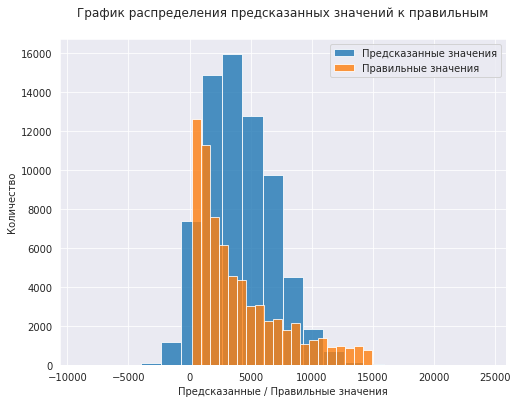

In [89]:
distribution_tar_pred(target_valid_ohe, test_predict_lin)

**Расчет RMSE на тестовой выборке у модели DecisionTreeRegressor**

In [90]:
test_predict_tree = best_model_tree_oe.predict(features_valid_oe)

test_rsme_tree = mean_squared_error(target_valid_oe, test_predict_tree, squared = False)
test_rsme_tree

1731.8893791799255

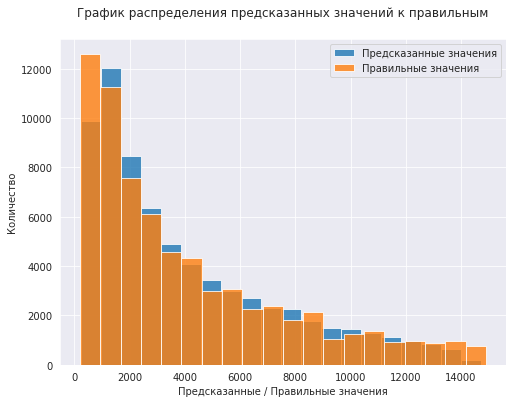

In [91]:
distribution_tar_pred(target_valid_oe, test_predict_tree)

**Расчет RMSE на тестовой выборке у модели RandomForestRegressor**

In [92]:
test_predict_forest = best_model_forest_oe.predict(features_valid_oe)

test_rsme_forest = mean_squared_error(target_valid_oe, test_predict_forest, squared = False)
test_rsme_forest

1541.010491014085

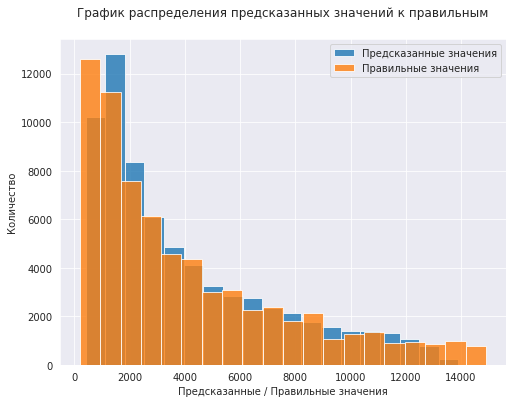

In [93]:
distribution_tar_pred(target_valid_oe, test_predict_forest)

**Расчет RMSE на тестовой выборке у модели CatBoostRegressor**

In [94]:
test_predict_cat = best_model_cat_oe.predict(features_valid_oe)

test_rsme_cat = mean_squared_error(target_valid_oe, test_predict_cat, squared = False)
test_rsme_cat

1576.3228363797475

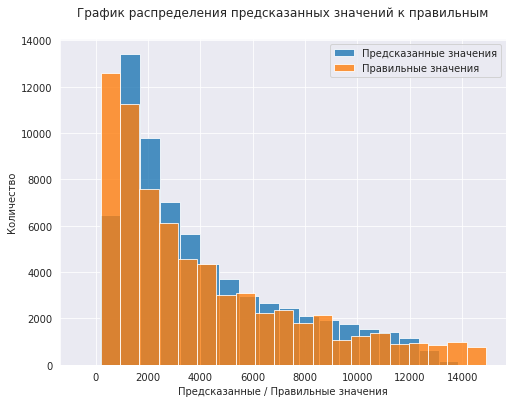

In [95]:
distribution_tar_pred(target_valid_oe, test_predict_cat)

**Расчет RMSE на тестовой выборке у модели LGBMRegressor**

In [96]:
test_predict_lgbm = best_model_lgbm_oe.predict(features_valid_oe)

test_rsme_lgbm = mean_squared_error(target_valid_oe, test_predict_lgbm, squared = False)
test_rsme_lgbm

2089.3385308483244

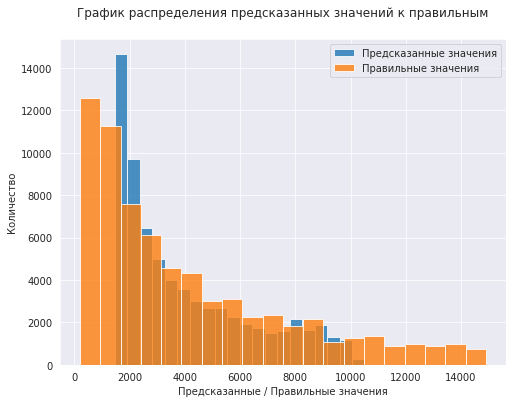

In [97]:
distribution_tar_pred(target_valid_oe, test_predict_lgbm)

**Расчет RMSE на тестовой выборке у модели DummyRegressor**

In [102]:
start = time.time()
model_dummy = DummyRegressor()
model_dummy.fit(features_train_oe, target_train_oe)
fit_time_dum = time.time() - start
predict_dummy = model_dummy.predict(features_valid_oe)
test_rsme_dum = mean_squared_error(target_valid_oe, predict_dummy, squared = False)
score_time_dum = time.time() - start
print(round(fit_time_dum, 6))
print(round(score_time_dum, 6))
test_rsme_dum

0.001419
0.002889


3618.734276099475

### Вывод:

**Общий датафрейм по результатам всех моделей**

In [103]:
rezult = pd.DataFrame(index=['Время обучения моделей', 'Время предсказания моделей', 'RMSE'],
                      columns=['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor',
                         'CatBoostRegressor', 'LGBMRegressor', 'DummyRegressor'])
rezult['LinearRegression'] = fit_time_lin, score_time_lin, test_rsme_lin
rezult['DecisionTreeRegressor'] = fit_time_tree, score_time_tree, test_rsme_tree
rezult['RandomForestRegressor'] = fit_time_forest, score_time_forest, test_rsme_forest
rezult['CatBoostRegressor'] = fit_time_cat, score_time_cat, test_rsme_cat
rezult['LGBMRegressor'] = fit_time_lgbm, score_time_lgbm, test_rsme_lgbm
rezult['DummyRegressor'] = fit_time_dum, score_time_dum, test_rsme_dum
rezult.T

,Время обучения моделей,Время предсказания моделей,RMSE
LinearRegression,18.790010,0.051642,2314.517092
DecisionTreeRegressor,0.611572,0.013183,1731.889379
RandomForestRegressor,18.469957,0.421761,1541.010491
CatBoostRegressor,13.400553,0.109789,1576.322836
LGBMRegressor,2.286752,0.121191,2089.338531
DummyRegressor,0.001419,0.002889,3618.734276


* При первичном анализе данных мы обнаружили большое кол-во пропусков, выбросов, дубликатов, не соответствие типа в правописание названия столбцов признаков и типов данных.
* В предобработке данных сразу удалили не информативные признаки для нашей задачи, из признака price удалили выбросы, во всех остальных столбцах где были пропуски заменили на значение 'unknown', только в признаке 'fuel_type' на значение 'other' и в 4 признаках заменили тип данных на бинарный, чтобы потом в них методом ближайших соседей KNN заполнить пропуски. Также удалили дубликаты и выбросы, посмотрели на зависимость между признаками и на зависимость самых коррелирующих признаков с целевым.
* Подготовили выборки для обучения моделей при помощи train_test_split и затем разделили признаки на категориальные и численные, так как для кодирования подходят только категориальные признаки затем объединили их обратно с численными. Закодировали данные двумя способами: OneHotEncoder и OrdinalEncoder. OneHotEncoder для модели LinearRegression, OrdinalEncoder для всех остальных моделей, так как это сложные модели. И для признаков закодированных методом OneHotEncoder промаштабировали их, для другого типа это не требуется.
* Обучили 6 моделей с подбором оптимальных параметров: 'LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor' и 'DummyRegressor'. Обучали модели и получали результат методом RandomizedSearchCV.
* Затем получили значение качества лучших моделей на тестовой выборке.

Для решения поставленной задачи наиболее подходящей моделью по соотношению качества и скорости является **CatBoostRegressor**:
RMSE = 1576.32, learning_rate_predict = 00:04:06 мин, с похожими результатами после этой модели идет RandomForestRegressor, из ее недостатков только скорость. Из самых низких по значениям критерий являются модели LinearRegression и DummyRegressor. Но стоит отметить, что все модели удовлетворяют условию RMSE < 2500. Кроме DummyRegressor, так ее мы построили для того, чтобы удостовериться в том, что вся наша работа была проделана не зря, поэтому она и должна была показать хуже результат чем все остальные.

**Наша модель полностью удовлетворяет всем условиям сервиса по продаже автомобилей с пробегом «Не бит, не крашен»**